Building a Logistic Regression Classifier

In [2]:
#Read the train data
import pandas as pd
from numba import jit

data = pd.read_csv('asylum_clean.csv')
data # 501053 rows


,idncase,idnproceeding,hearing_loc_code,ij_code,comp_date,lawyer,defensive,natid,written,flag_decisionerror_strdes,...,denydeny,hour_start,morning,lunchtime,numcases_judgeday,numcases_judge,numcases_court_hearing,Year_Appointed_SLR,experience,experience8
0,3746462,2113503,AGA,AA,15131,1,1,44,0,0,...,NaN,8,1,0,2,3,579,1995,6,0
1,3635079,1980165,AGA,AA,15131,1,0,44,0,0,...,NaN,10,1,0,2,3,579,1995,6,0
2,3998888,2439804,AGA,AA,15132,1,0,44,0,0,...,0,10,1,0,1,3,579,1995,6,0
3,6441123,5102185,FLO,AA,18435,0,1,94,0,0,...,NaN,8,1,0,1,3,1688,1995,15,1
4,6443250,5104754,FLO,AA,18436,0,1,54,0,0,...,NaN,8,1,0,1,3,1688,1995,15,1
5,6414808,5147864,FLO,AA,18437,0,1,54,0,0,...,1,13,0,1,1,3,1688,1995,15,1
6,4434646,3009829,LOS,AA,15606,1,0,44,0,0,...,NaN,8,1,0,2,2,55075,1995,7,0
7,4469619,3051107,LOS,AA,15606,1,0,108,0,0,...,NaN,8,1,0,2,2,55075,1995,7,0
8,2891398,1198824,LVG,AA,13975,1,0,72,0,0,...,NaN,9,1,0,1,3,2547,1995,3,0
9,3569624,1903006,LVG,AA,14010,1,0,72,0,0,...,NaN,9,1,0,1,3,2547,1995,3,0


In [3]:
# Check if there is duplicated 'idncase' 
data_duplicated = data.duplicated('idncase', keep =False)
data_duplicated[data_duplicated==True]

# Visualize data sorted by 'idncase' and 'idnproceeding'
data_duplicated_sorted = data[data_duplicated].sort_values(by=['idncase', 'idnproceeding'])

# keep last proceeding on the same idncase
data_duplicated_sorted_keep_last = data_duplicated_sorted.duplicated('idncase', keep ='first')
duplicated_to_keep = data_duplicated_sorted[data_duplicated_sorted_keep_last==True] # 22783 rows
duplicated_to_keep # 22783 rows

# Drop all duplicated idncase from data
data_duplicated_idncase_removed = data.drop_duplicates('idncase', keep =False) 
data_duplicated_idncase_removed.shape # 456810 rows

# Count duplicated: all rows
data_duplicated[data_duplicated==True].shape # 44243 rows

# Merge data_duplicated_idncase_removed and duplicated_to_keep
data_no_duplicates = data_duplicated_idncase_removed.append(duplicated_to_keep, ignore_index=True)
data_no_duplicates.shape # 479593 rows matching the expected


(479593, 60)

In [35]:
# Check for missing values by column 'grant'
data_no_duplicates['grant'].isnull().values.any() # there are missing values!

# Check for missing values by column 'grantraw'
data_no_duplicates['grantraw'].isnull().values.any() # no NaN value
data_no_duplicates[data_no_duplicates['grantraw']==1] # 167912 rows with 'grantraw'==1
data_no_duplicates[data_no_duplicates['grantraw']==0] # 311681 rows with 'grantraw'==0 No missing values!

# Check for missing values by column 'hearing_loc_code'
data_no_duplicates['hearing_loc_code'].isnull().values.any() # No missing values!
data_no_duplicates['hearing_loc_code'].unique()
data_no_duplicates['hearing_loc_code'].unique().shape # 247 unique locations

# Check for missing values by column 'natid'
data_no_duplicates['natid'].isnull().values.any() # There are missing values!
data_no_duplicates['natid'].unique()
data_no_duplicates['natid'].unique().shape # 227 unique natid including 'NaN'
data_no_duplicates['natid'].isnull().sum() # 337 rows with missing values on column 'natid'

# Prepare data for basic Log Reg using features 'hearing_loc_code', 'natid', and 'grantraw' as X
data_X = data_no_duplicates[['hearing_loc_code', 'natid', 'grantraw']]

# Remove 337 rows where 'natid' has missing values
data_X = data_X.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

# Codify data on hearing_loc_code as numbers
@jit
def map_to_dict():
    dicti = {}
    ad = -1
    for i in data_no_duplicates['hearing_loc_code'].unique():
        ad += 1
        dicti[i] = ad
    return dicti
mapp = map_to_dict() # dictionary where key = hearing_loc_code and value = number

@jit
def codify_in_place(mapp, data_X):
    data_X.hearing_loc_code.replace(to_replace=mapp, inplace=True)
    return data_X
codify_in_place(mapp, data_X)
data_X
# Random split into train and test
import numpy as np
split = np.random.rand(len(data_X)) < .8
train = data_X[split]
test = data_X[~split]

In [36]:
train.shape # 383673 rows
test.shape # 95583 rows

(95934, 3)

In [37]:
# Implement Log Reg
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C = 1e30)
logreg.fit(train.drop('grantraw', 1), train['grantraw'])

LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

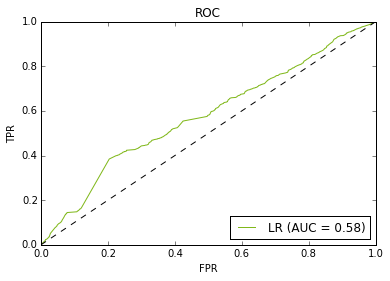

In [38]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

@jit
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(test['grantraw'], logreg.predict_proba(test.drop('grantraw', 1))[:,1], 'LR')  

plt.show()